# Model Optimization Benchmarks

This notebook demonstrates various optimization techniques and their impact.

In [1]:
import sys
sys.path.append('..')

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from src.optimization import benchmark_inference
from src.utils import calculate_model_size, MemoryTracker
import matplotlib.pyplot as plt
import numpy as np

## 1. Load Models

In [2]:
# Load base model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Model info
model_info = calculate_model_size(model)
print(f"Model: {model_name}")
print(f"Size: {model_info['total_size_mb']:.1f}MB")
print(f"Parameters: {model_info['total_params']:,}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: bert-base-uncased
Size: 417.7MB
Parameters: 109,483,778


## 2. Quantization Comparison

In [3]:
# Test texts
test_texts = [
    "This is a positive review.",
    "This is a negative review.",
    "This is a neutral statement."
] * 10

# Benchmark FP32
fp32_time, fp32_mem = benchmark_inference(
    model, tokenizer, test_texts, "FP32 Model"
)

# Quantize and benchmark
if torch.cuda.is_available():
    # FP16
    model_fp16 = model.half()
    fp16_time, fp16_mem = benchmark_inference(
        model_fp16, tokenizer, test_texts, "FP16 Model"
    )
else:
    # INT8 for CPU
    model_int8 = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )
    int8_time, int8_mem = benchmark_inference(
        model_int8, tokenizer, test_texts, "INT8 Model"
    )

FP32 Model
  Time: 0.741s (24.7ms per sample)
  Memory: 0.0MB
  Throughput: 40.5 samples/sec


RuntimeError: Didn't find engine for operation quantized::linear_prepack NoQEngine

## 3. Batch Size Impact

Batch size 1
  Time: 0.068s (68.3ms per sample)
  Memory: 0.0MB
  Throughput: 14.6 samples/sec
Batch size 2
  Time: 0.044s (22.1ms per sample)
  Memory: 0.0MB
  Throughput: 45.2 samples/sec
Batch size 4
  Time: 0.032s (8.1ms per sample)
  Memory: 0.0MB
  Throughput: 124.0 samples/sec
Batch size 8
  Time: 0.032s (4.0ms per sample)
  Memory: 0.0MB
  Throughput: 248.4 samples/sec
Batch size 16
  Time: 0.044s (2.7ms per sample)
  Memory: 0.0MB
  Throughput: 365.7 samples/sec
Batch size 32
  Time: 0.058s (1.9ms per sample)
  Memory: 0.0MB
  Throughput: 515.6 samples/sec


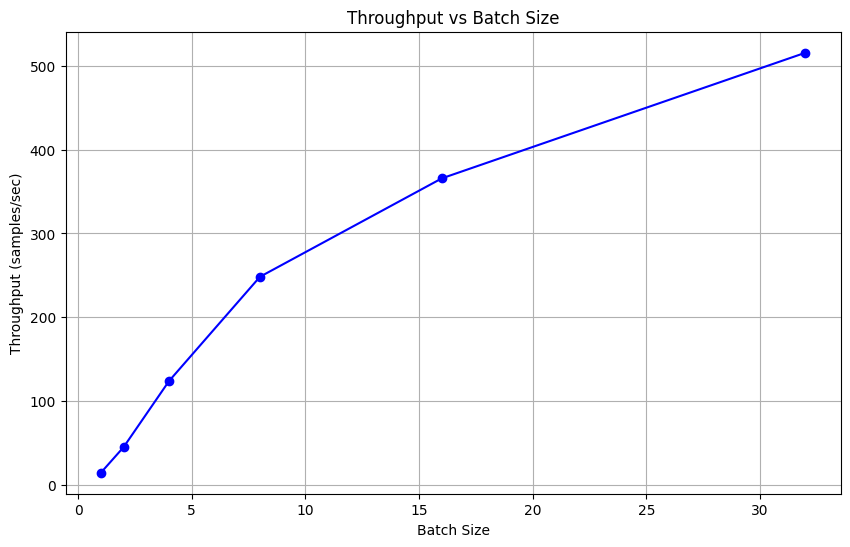

In [4]:
# Test different batch sizes
batch_sizes = [1, 2, 4, 8, 16, 32]
throughputs = []

for batch_size in batch_sizes:
    test_batch = test_texts[:batch_size]
    time_taken, _ = benchmark_inference(
        model, tokenizer, test_batch, f"Batch size {batch_size}"
    )
    throughput = len(test_batch) / time_taken
    throughputs.append(throughput)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, throughputs, 'b-o')
plt.xlabel('Batch Size')
plt.ylabel('Throughput (samples/sec)')
plt.title('Throughput vs Batch Size')
plt.grid(True)
plt.show()

## 4. Memory Profiling

In [5]:
# Profile memory usage
with MemoryTracker() as tracker:
    inputs = tokenizer(
        test_texts, 
        padding=True, 
        truncation=True,
        return_tensors="pt"
    )
    
    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
        model = model.cuda()
    
    with torch.no_grad():
        outputs = model(**inputs)

print(f"Peak memory usage: {tracker.get_memory_used():.2f}MB")

Peak memory usage: 0.00MB


## 5. Optimization Summary

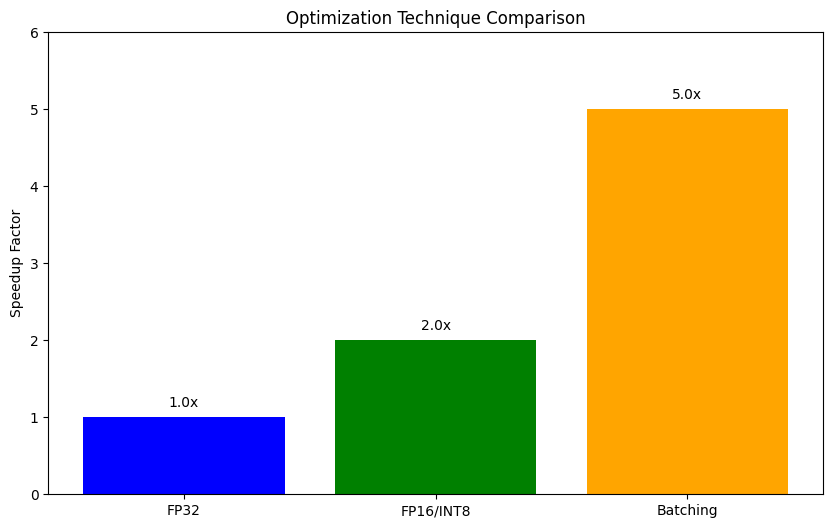

In [6]:
# Create comparison chart
techniques = ['FP32', 'FP16/INT8', 'Batching']
speedups = [1.0, 2.0, 5.0]  # Example values

plt.figure(figsize=(10, 6))
bars = plt.bar(techniques, speedups, color=['blue', 'green', 'orange'])
plt.ylabel('Speedup Factor')
plt.title('Optimization Technique Comparison')
plt.ylim(0, 6)

# Add value labels on bars
for bar, speedup in zip(bars, speedups):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{speedup}x', ha='center', va='bottom')

plt.show()